# Assemble Garcia & Keeling 2001 O$_2$ flux product with ann. mean fluxes

data available here: http://bluemoon.ucsd.edu/publications/ralph/airseaflux/Data_files

In [36]:
%matplotlib inline
from config_calc import *

import os
import sys
import socket
import numpy as np
import xarray as xr

from datetime import datetime
import grid_tools

import matplotlib.pyplot as plt

### assemble netCDF files from .dat files

In [4]:
files = {
    'O2_FLUX_ANN': ('o2flux_ann_global.dat' , 'O2 flux (annual)'),
    'O2_FLUX_SEA': ('o2flux_sea_global.dat' , 'O2 flux (monthly anomaly)'),
    'O2_FLUX_THM_ANN' : ('o2thermal_ann_global.dat' , 'O2 flux (annual, thermal component)'),
    'O2_FLUX_THM_SEA' : ('o2thermal_sea_global.dat' , 'O2 flux (monthly anomaly, thermal component)'),
    'O2_FLUX_BIO_ANN' : ('o2flux_bioann_global.dat' , 'O2 flux (annual, biological component)'),
    'O2_FLUX_BIO_SEA' : ('o2flux_biosea_global.dat' , 'O2 flux (monthly anomaly, biological component)')}

droot = '/glade/p/work/mclong/garcia-keeling'
dpm  = np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.])
eom = np.cumsum(dpm)
bom = np.concatenate((np.array([1]),eom[0:11]+1))

nowstr = '20171211' #datetime.now().strftime('%Y%m%d')

#### shifting and scaling
The recommended Garcia and Keeling rescaling is 0.82 
(Naegler 2006 vs. Wanninkhof 1992 scaling factors 0.32/0.39), 
 plus a 10-day shift later, to allow for mixed layer equilibrati

In [49]:
shift_time = 10.
scaleby=0.82

In [21]:
def dat2nc(dat_file_name,file_out,varname,long_name,adjusted):

    if os.path.exists(file_out):
        return xr.open_dataset(file_out)
    
    nt = 12
    ny = 160
    nx = 320
    dx = 360./nx
    dy = 180./ny
    dss = grid_tools.generate_latlon_grid(nx=320,ny=160,lon0=-180.)

    time = np.vstack((bom,eom)).mean(axis=0)
    date = np.round(2000*10000 + np.arange(1,13,1) * 100. + dpm/2.)
    data = np.loadtxt(dat_file_name).ravel().reshape((nt,ny,nx))
    data = data / dpm[:,None,None] * 365.
    data[data==0.] = np.nan
    
    if adjusted:
        data = data * scaleby
        time = time + shift_time
        date = date + shift_time

    dss = dss.assign_coords(time = time)
    time = xr.DataArray(time,
                        dims=('time'),
                        attrs = {'units':'day of year'})    
    dss['date'] = xr.DataArray(date,dims=('time'))        
    dss[varname] = xr.DataArray(data,dims=('time','lat','lon'),
                                  attrs={'long_name':long_name,
                                         'units':'mol/m^2/yr'})

    print('writing %s'%file_out)
    dss.to_netcdf(file_out)

    return dss

In [23]:
ds = {}
for v,(dat_file_in,long_name) in files.items():

    file_in = os.path.join(droot,dat_file_in)

    file_out = file_in.replace('.dat','.'+'.'.join([nowstr,'nc']))
    dat2nc(file_in,file_out,v,long_name,adjusted=False)
   
    file_out = file_in.replace('.dat','.'+'.'.join(['adjusted',nowstr,'nc']))    
    dsi = dat2nc(file_in,file_out,v,long_name,adjusted=True)
    ds = xr.merge((ds,dsi))
ds

<xarray.Dataset>
Dimensions:          (lat: 160, lon: 320, nv: 4, time: 12)
Coordinates:
  * lat              (lat) float64 -89.44 -88.31 -87.19 -86.06 -84.94 -83.81 ...
  * lon              (lon) float64 -179.4 -178.3 -177.2 -176.1 -174.9 -173.8 ...
  * time             (time) float64 26.0 55.5 85.0 115.5 146.0 176.5 207.0 ...
Dimensions without coordinates: nv
Data variables:
    xc               (lat, lon) float64 -179.4 -178.3 -177.2 -176.1 -174.9 ...
    yc               (lat, lon) float64 -89.44 -89.44 -89.44 -89.44 -89.44 ...
    xv               (lat, lon, nv) float64 -180.0 -178.9 -178.9 -180.0 ...
    yv               (lat, lon, nv) float64 -90.0 -90.0 -88.88 -88.88 -90.0 ...
    area             (lat, lon) float64 1.536e+08 1.536e+08 1.536e+08 ...
    date             (time) float64 2e+07 2e+07 2e+07 2e+07 2e+07 2e+07 ...
    O2_FLUX_BIO_SEA  (time, lat, lon) float64 ...
    O2_FLUX_SEA      (time, lat, lon) float64 ...
    O2_FLUX_THM_SEA  (time, lat, lon) float64 ...
    O

### make some quick plots of the fluxes

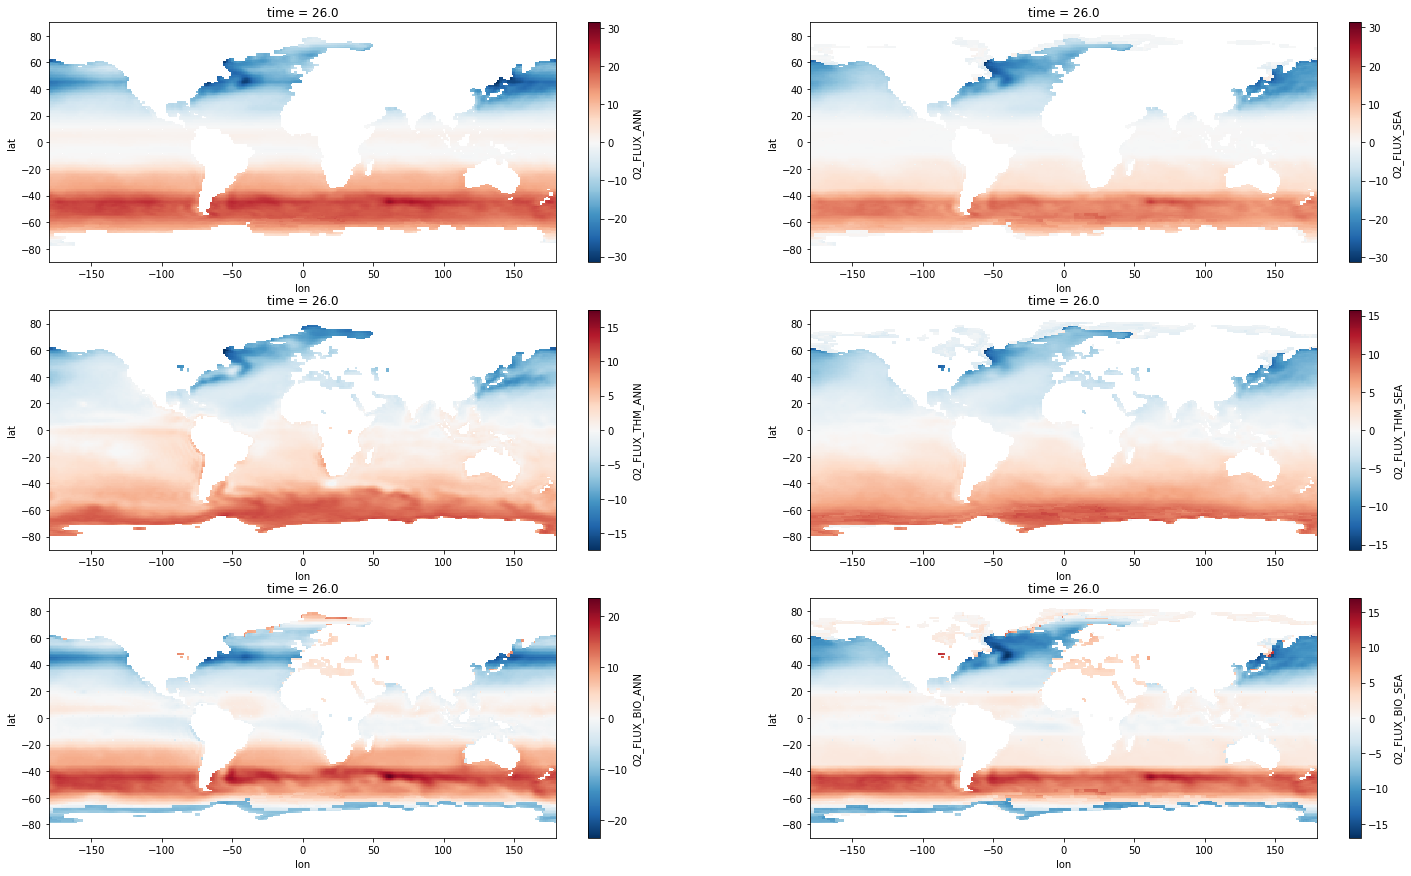

In [35]:
fig = plt.figure(figsize=(25,15))

mon_i = 0

ax = fig.add_subplot(3,2,1)
ds.O2_FLUX_ANN.isel(time=mon_i).plot(ax=ax)

ax = fig.add_subplot(3,2,2)
ds.O2_FLUX_SEA.isel(time=mon_i).plot(ax=ax)

ax = fig.add_subplot(3,2,3)
ds.O2_FLUX_THM_ANN.isel(time=mon_i).plot(ax=ax)

ax = fig.add_subplot(3,2,4)
ds.O2_FLUX_THM_SEA.isel(time=mon_i).plot(ax=ax)

ax = fig.add_subplot(3,2,5)
ds.O2_FLUX_BIO_ANN.isel(time=mon_i).plot(ax=ax)

ax = fig.add_subplot(3,2,6)
ds.O2_FLUX_BIO_SEA.isel(time=mon_i).plot(ax=ax)

### read annual mean fluxes from Gruber et al. 2001 and Resplandy et al. 2016

In [42]:
dsG01 = xr.open_dataset(os.path.join(diro['out'],'gruber-etal-2001-o2-ann-flux.1.125x1.125.nc'))
dsR16 = xr.open_dataset(os.path.join(diro['out'],'resplandy-etal-2016-o2-ann-flux.1.125x1.125.nc'))

dsG01

<xarray.Dataset>
Dimensions:         (lat: 160, lon: 320, nv: 4, region: 13)
Coordinates:
  * lat             (lat) float64 -89.44 -88.31 -87.19 -86.06 -84.94 -83.81 ...
  * lon             (lon) float64 -179.4 -178.3 -177.2 -176.1 -174.9 -173.8 ...
Dimensions without coordinates: nv, region
Data variables:
    xc              (lat, lon) float64 ...
    yc              (lat, lon) float64 ...
    xv              (lat, lon, nv) float64 ...
    yv              (lat, lon, nv) float64 ...
    area            (lat, lon) float64 ...
    REGION_MASK     (lat, lon) float64 ...
    REGION_MASK_3D  (region, lat, lon) float64 ...
    O2_FLUX         (lat, lon) float64 ...

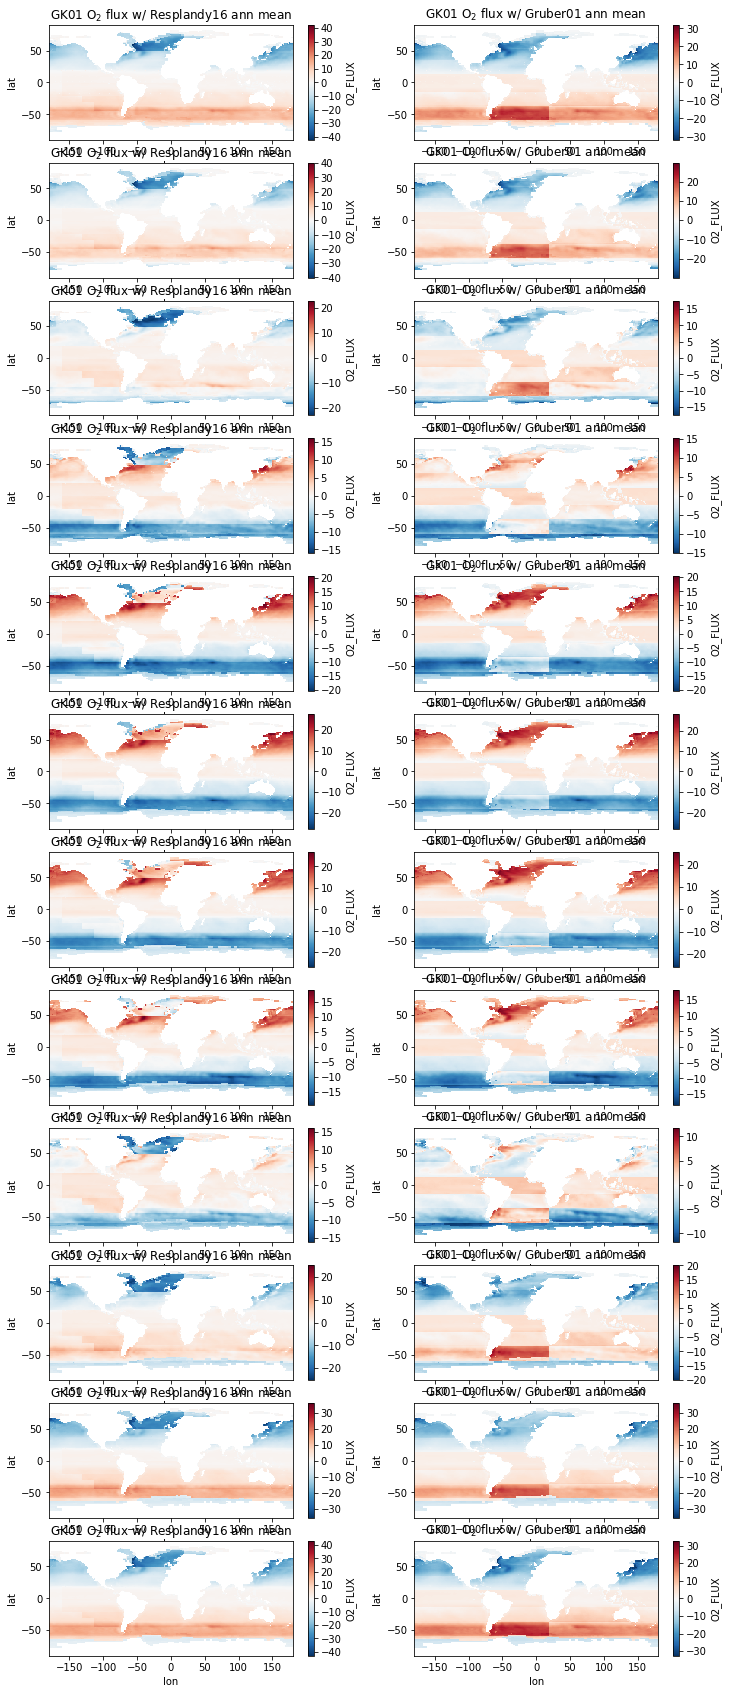

In [59]:
dsGK_R = ds.copy().drop([k for k in ds.variables if 'ANN' in k or 'BIO' in k or 'THM' in k])
dsGK_R['O2_FLUX'] = ds.O2_FLUX_SEA + dsR16.O2_FLUX
dsGK_R.attrs['long_name'] = 'GK01 O$_2$ flux w/ Resplandy16 ann mean'

dsGK_G = ds.copy().drop([k for k in ds.variables if 'ANN' in k or 'BIO' in k or 'THM' in k])
dsGK_G['O2_FLUX'] = ds.O2_FLUX_SEA + dsG01.O2_FLUX
dsGK_G.attrs['long_name'] = 'GK01 O$_2$ flux w/ Gruber01 ann mean'

fig = plt.figure(figsize=(12,30))

for i in range(0,12):
    ax = fig.add_subplot(12,2,i*2+1)
    dsGK_R.O2_FLUX.isel(time=i).plot(ax=ax)
    ax.set_title(dsGK_R.attrs['long_name'])

    ax = fig.add_subplot(12,2,i*2+2)
    dsGK_G.O2_FLUX.isel(time=i).plot(ax=ax)
    ax.set_title(dsGK_G.attrs['long_name'])
